# Probablistic model for spot latitude distribution

Load spots properties from `friedrich`:

In [1]:
%matplotlib inline
# Import dev version of friedrich:
import sys, os 
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
from friedrich.analysis import Transit, Spot, Measurement, MCMCResults
from friedrich.lightcurve import hat11_params_morris_is_100
from glob import glob

archive_paths = sorted(glob('/local/tmp/friedrich/hat11_flip_lambda/chains???.hdf5'))
# archive_paths = sorted(glob('/Users/bmmorris/data/hat11_flip_lambda/chains???.hdf5'))

print('load results')
transits = []
all_times = []
for archive_path in archive_paths:
    m = MCMCResults(archive_path, hat11_params_morris_is_100())
    all_times.extend(m.lc.times.jd)
    spots = m.get_spots()
    transits.append(Transit(spots))


load results


In [2]:
from friedrich.orientation import times_to_occulted_lat_lon
from friedrich.lightcurve import hat11_params_morris_is_100

transit_params = hat11_params_morris_is_100()
all_lats = []
all_lons = []
all_amps = []
all_lats_errors = []
all_spot_times = []
all_BICs = []
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)
        all_lats.append(latitude)
        all_lons.append(longitude)
        all_amps.append(spot.amplitude.value)
        all_spot_times.append(spot.t0.value)
        all_BICs.append(spot.delta_BIC)
        all_lats_errors.append(np.mean([spot.amplitude.upper, spot.amplitude.lower]))
all_lats = np.array(all_lats)
all_lats_errors = np.array(all_lats_errors)
all_lons = np.array(all_lons)
all_amps = np.array(all_amps)
all_spot_times = np.array(all_spot_times)
all_BICs = np.array(all_BICs)

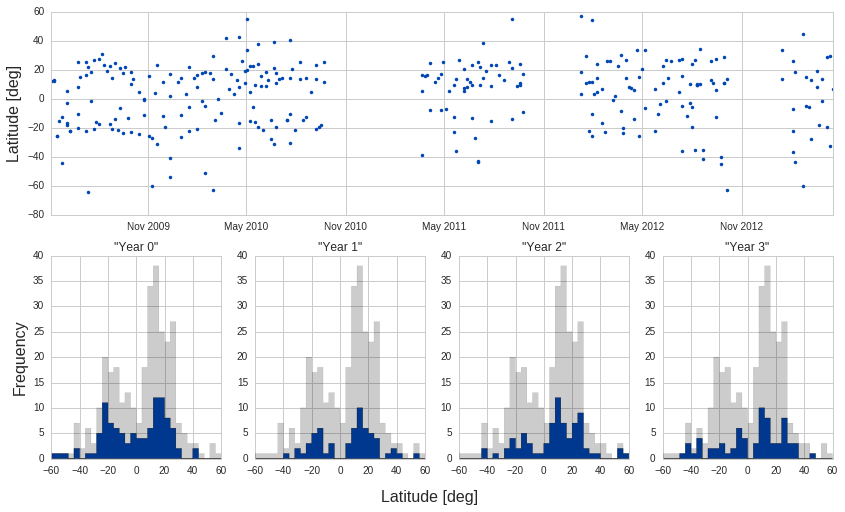

In [3]:
#all_amps
# plt.plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
#               np.degrees(all_lats[all_BICs > 10]), '.')
from astropy.time import Time

import seaborn as sns
sns.set_style('whitegrid')

n_panels = 4
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 4)
ax0 = plt.subplot(gs[0, :])
ax1 = [plt.subplot(gs[1, i]) for i in range(n_panels)]

#fig, ax = plt.subplots(1, n_panels, figsize=(14, 3))
first_spot = all_spot_times[all_BICs > 10].min()
last_spot = all_spot_times[all_BICs > 10].max()
first_to_last = last_spot - first_spot
fraction_gt_median = np.zeros(n_panels)

lathistcolor = '#0047b3'

ax0.plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
              np.degrees(all_lats[all_BICs > 10]), '.', color=lathistcolor)

for i in range(n_panels):
    extent = [-60, 60]
    within_time_bin = ((all_spot_times[all_BICs > 10] - first_spot > 
                        i/n_panels*first_to_last) & 
                       (all_spot_times[all_BICs > 10] - first_spot < 
                        (i+1)/n_panels*first_to_last))
    lats_in_time_bin = np.degrees(all_lats[all_BICs > 10][within_time_bin])
    ax1[i].hist(lats_in_time_bin, 30, range=extent, histtype='stepfilled', color=lathistcolor)

    ax1[i].hist(np.degrees(all_lats[all_BICs > 10]), 30, histtype='stepfilled',
                range=extent, alpha=0.2, color='k', zorder=10)

    ax1[i].set_xlim(extent)
    
    ax1[i].set(title='"Year {0}"'.format(i))
    
    if i == 0:
        segment_zero_mean = np.median(lats_in_time_bin)
    fraction_gt_median[i] = np.count_nonzero(lats_in_time_bin > segment_zero_mean)/len(lats_in_time_bin)

ax1[0].set_ylabel('Frequency', fontsize=16)
ax0.set_ylabel('Latitude [deg]', fontsize=16)


fig.text(0.5, 0.05, 'Latitude [deg]', ha='center', fontsize=16)
# fig.savefig(os.path.join(dropbox_path, 'figures', 'latitude_distribution.png'), 
#             bbox_inches='tight', dpi=1500)
#fig.subplots_adjust()

In [4]:
sns.reset_orig()
%matplotlib inline

ignore_high_latitudes = ((all_lats > np.radians(-40)) & (all_lats < np.radians(50)))
significance_cutoff = np.atleast_2d(all_BICs > 10).T
significant_latitudes = np.degrees(all_lats[significance_cutoff & ignore_high_latitudes])
significant_times = np.atleast_2d(all_spot_times).T[significance_cutoff & ignore_high_latitudes]
significant_amps = np.atleast_2d(all_amps).T[significance_cutoff & ignore_high_latitudes]
significant_latitudes_errors = np.ones_like(significant_latitudes) * 5

# Gaussian mixture model with scikit-learn

Note that it is not well physically motivated to model the distribution as three gaussians, because while it may be a good approximation to model the active latitudes with Gaussians, the perhaps uniform background of spots distributed isotropically on the surface of the star would be modeled with a cosine function.  

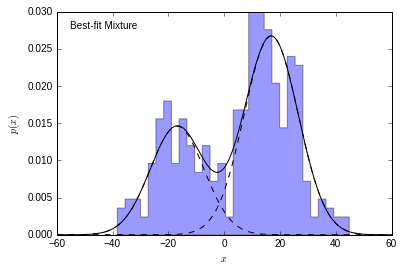

In [5]:
from sklearn.mixture import GMM

X = np.atleast_2d(significant_latitudes).T

fig, ax = plt.subplots()
M_best = GMM(2).fit(X)#models[np.argmin(AIC)]

x = np.atleast_2d(np.linspace(-60, 60, 1000)).T
# logprob, responsibilities = M_best.eval(x)
logprob = M_best.score(x)
responsibilities = M_best.predict_proba(x)

pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

In [6]:
init_offset = np.mean(M_best.means_)

# Modified Gaussian Mixture Model with `emcee`

...with a cosine-bias centered on the stellar equator.

In [7]:
import emcee
from scipy.misc import logsumexp

def gaussian(x, mean, lnvar, amp):
    var = np.exp(lnvar)
    return amp/np.sqrt(2*np.pi*var) * np.exp(-0.5 * (x - mean)**2 / var)

def lnlikelihood_gaussian(x, yerr, mean, lnvar, amp):
    var = np.exp(lnvar) + yerr**2
#     return  -0.5 * (x - mean)**2 / var - 0.5 * np.log(2*np.pi*var) + np.log(amp)
    return  -0.5 * ((x - mean)**2 / var + np.log(var)) + np.log(amp)

def lnlikelihood_sum_gaussians(parameters, x, yerr):
    a1, mean_latitude, lnv1, lnv2, new_i_s = parameters
    a2 = 1 - a1
    delta_i_s = transit_params.inc_stellar - new_i_s
    l1 = mean_latitude - delta_i_s
    l2 = -mean_latitude - delta_i_s

    ln_likes = (lnlikelihood_gaussian(x, yerr, l1, lnv1, a1),
                lnlikelihood_gaussian(x, yerr, l2, lnv2, a2))
    return np.sum(np.logaddexp.reduce(ln_likes)), ln_likes

def minimize_this(parameters, x, yerr):
    return -1*lnlikelihood_sum_gaussians(parameters, x, yerr)

def model(parameters, x):
    a1, mean_latitude, lnv1, lnv2, new_i_s = parameters
    a2 = 1 - a1
    delta_i_s = transit_params.inc_stellar - new_i_s
    l1 = mean_latitude - delta_i_s
    l2 = -mean_latitude - delta_i_s
    return (gaussian(x, l1, lnv1, a1) + gaussian(x, l2, lnv2, a2))

def model_components(parameters, x):
    a1, mean_latitude, lnv1, lnv2, new_i_s = parameters
    a2 = 1 - a1
    delta_i_s = transit_params.inc_stellar - new_i_s
    l1 = mean_latitude - delta_i_s
    l2 = -mean_latitude - delta_i_s
    return np.array([gaussian(x, l1, lnv1, a1), gaussian(x, l2, lnv2, a2)]).T

def lnprior(parameters):
    a1, mean_latitude, lnv1, lnv2, new_i_s = parameters
    v1, v2 = np.exp([lnv1, lnv2])
    if (mean_latitude > 0 and 40 < new_i_s < 110 and v1 > 0 and v2 > 0 and 0 < a1 < 1):
        return 0.0
    return -np.inf

def lnprob(parameters, x, yerr):
    lp = lnprior(parameters)
    if not np.isfinite(lp):
        return -np.inf, None
    lnlike, blobs = lnlikelihood_sum_gaussians(parameters, x, yerr)
    return lp + lnlike, blobs

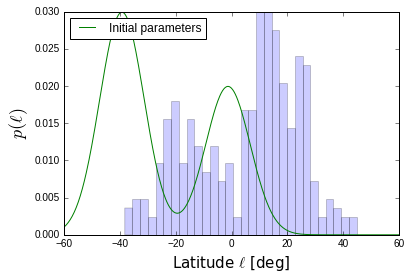

In [8]:
initp = [0.4, 19, np.log(8**2), np.log(8**2), 80 + init_offset]

plt.hist(significant_latitudes, 30, normed=True, alpha=0.2)
test_lats = np.linspace(-60, 60, 500)
plt.plot(test_lats, model(initp, test_lats), label='Initial parameters')
plt.legend(loc='upper left')
plt.xlabel('Latitude $\ell$ [deg]', fontsize=15)
plt.ylabel('$p(\ell)$', fontsize=18)

In [9]:
ndim, nwalkers = len(initp), 4*len(initp)
p0 = [np.array(initp) + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(significant_latitudes, significant_latitudes_errors),
                                threads=4)

pos = sampler.run_mcmc(p0, 500)[0]
samples = sampler.run_mcmc(pos, 2500)

[  0.66831644  17.09903413   4.36169122   3.98943891  99.51065054]


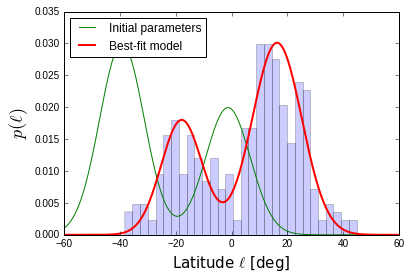

In [10]:
burnin = 1000
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

bestp = np.median(samples, axis=0)

plt.hist(significant_latitudes, 30, normed=True, alpha=0.2)
test_lats = np.linspace(-60, 60, 500)
plt.plot(test_lats, model(initp, test_lats), label='Initial parameters')
plt.plot(test_lats, model(bestp, test_lats), lw=2, label='Best-fit model')
plt.legend(loc='upper left')
plt.xlabel('Latitude $\ell$ [deg]', fontsize=15)
plt.ylabel('$p(\ell)$', fontsize=18)
print(bestp)

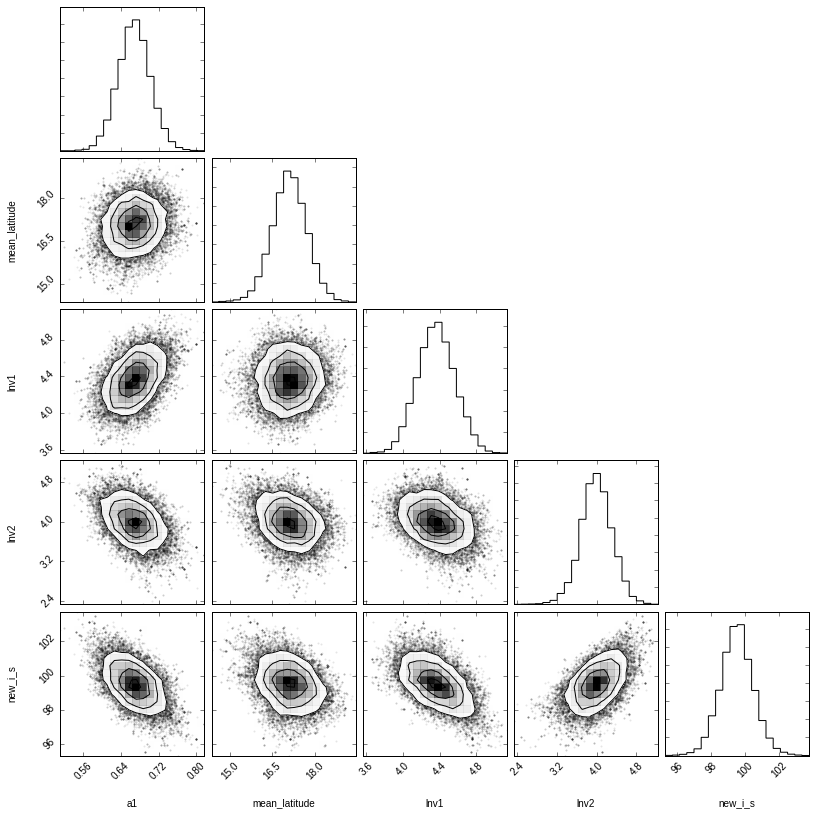

In [11]:
import corner 

# a1, m1, v1, a2, m2, v2
labels = "a1, mean_latitude, lnv1, lnv2, new_i_s".split(', ')
fig = corner.corner(samples, labels=labels)

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


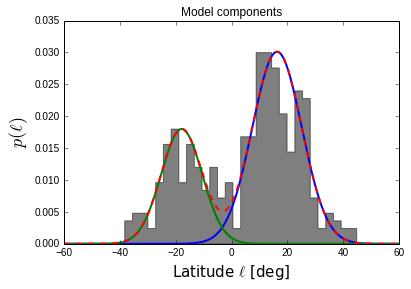

In [12]:

delta_i_s = transit_params.inc_stellar - bestp[4]
l1 = bestp[1] - delta_i_s
l2 = -bestp[1] - delta_i_s
components = np.array([gaussian(test_lats, l1, bestp[2], bestp[0]), 
                       gaussian(test_lats, l2, bestp[3], 1-bestp[0])]).T

plt.hist(significant_latitudes, 30, normed=True, 
         alpha=0.5, histtype='stepfilled', color='k')

plt.title('Model components')
plt.plot(test_lats, components, lw=2)
plt.plot(test_lats, model(bestp, test_lats), ls='--', lw=2)
plt.legend(loc='upper left')
plt.xlabel('Latitude $\ell$ [deg]', fontsize=15)
plt.ylabel('$p(\ell)$', fontsize=18)
plt.show()

In [13]:
print("mean latitudes: {0}".format(bestp[1]))
print("i_s: {0}".format(bestp[4]))

mean latitudes: 17.09903413402637
i_s: 99.51065054384365


***

Draw from this distribution: 

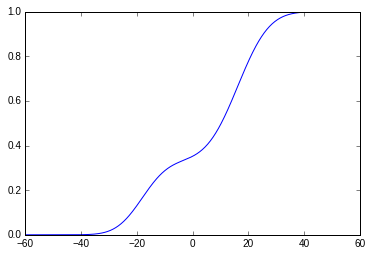

In [14]:
cdf = np.cumsum(model(bestp, test_lats))
cdf /= np.max(cdf)

pred_lat = lambda x: np.interp(x, cdf, test_lats)

plt.plot(test_lats, cdf)

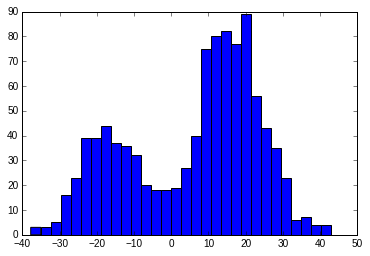

In [15]:
plt.hist(pred_lat(np.random.rand(1000)), 30);

*** 

calculate probability of being in either latitude: 

In [16]:
norm = 0.0
post_prob_g1 = np.zeros(len(significant_latitudes))
post_prob_g2 = np.zeros(len(significant_latitudes))
for i in range(sampler.chain.shape[1]):
    for j in range(sampler.chain.shape[2]):
        like_g1, like_g2 = sampler.blobs[i][j]
        post_prob_g1 += np.exp(like_g1 - np.logaddexp(like_g1, like_g2))
        post_prob_g2 += np.exp(like_g2 - np.logaddexp(like_g1, like_g2))
        norm += 1
post_prob_g1 /= norm
post_prob_g2 /= norm

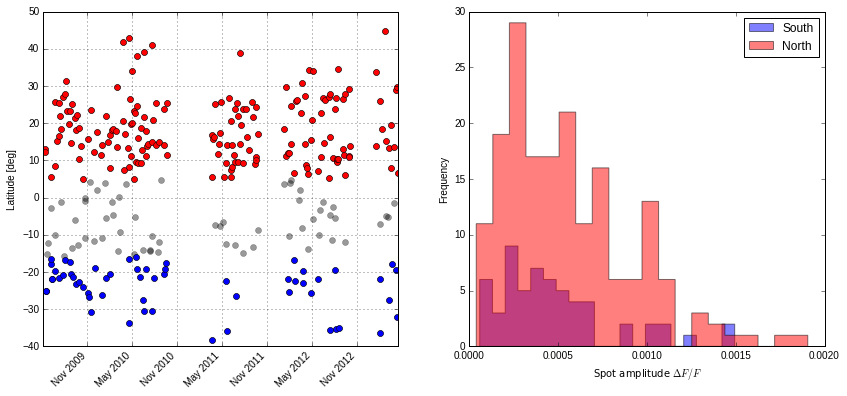

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot_date(Time(significant_times, format='jd').plot_date, 
             significant_latitudes, 'ko', alpha=0.4)


likely_g1 = post_prob_g1 > 0.95
likely_g2 = post_prob_g2 > 0.95

ax[0].plot_date(Time(significant_times[likely_g1], format='jd').plot_date, 
             significant_latitudes[likely_g1], 'ro')
ax[0].plot_date(Time(significant_times[likely_g2], format='jd').plot_date, 
             significant_latitudes[likely_g2], 'bo')
ax[0].grid()
for l in ax[0].get_xticklabels():
    l.set_rotation(45)
    l.set_ha('right')

ax[1].hist(significant_amps[likely_g2], 20, histtype='stepfilled', 
           color='b', alpha=0.5, label='South')

ax[1].hist(significant_amps[likely_g1], 20, histtype='stepfilled', 
           color='r', alpha=0.5, label='North')
ax[1].legend()

ax[0].set_ylabel('Latitude [deg]')
ax[1].set(ylabel='Frequency', xlabel='Spot amplitude $\Delta F/F$')

plt.show()

***

## Repeat the above analysis for the Sun:

In [18]:
paths = glob('/local/tmp/Mt_Wilson_Tilt/*/sspot??.dat')
# paths = glob('/Users/bmmorris/data/Mt_Wilson_Tilt/*/sspot??.dat')

from astropy.time import Time
import astropy.units as u
from astropy.table import Table

def split_interval(string, n, cast_to_type=float):
    return [cast_to_type(string[i:i+n]) for i in range(0, len(string), n)]

all_years_array = []

header = ("jd n_spots_leading n_spots_following n_spots_day_1 n_spots_day_2 "
          "rotation_rate latitude_drift latitude_day_1 latitude_day_2 longitude_day_1 "
          "longitude_day_2 area_day_1 area_day_2 group_latitude_day_1 group_longitude_day_1 "
          "group_area_day_1 group_area_day_2 polarity_day_1 polarity_change tilt_day_1 tilt_day_2 "
          "group_rotation_rate group_latitude_drift").split()

for path in paths:
    f = open(path).read().splitlines()

    n_rows = len(f) // 3
    n_columns = 23#18
    yearly_array = np.zeros((n_rows, n_columns))

    for i in range(n_rows):
        # First five ints specify time, afterwards specify sunspot data
        int_list = split_interval(f[0+i*3][:18], 2, int)
        month, day, year_minus_1900, hour, minute = int_list[:5]
        year = year_minus_1900 + 1900
        jd = Time("{year:d}-{month:02d}-{day:02d} {hour:02d}:{minute:02d}"
                  .format(**locals())).jd
        row = [jd] + int_list[5:] + split_interval(f[1+i*3], 7) + split_interval(f[2+i*3][1:], 7)
        yearly_array[i, :] = row

    all_years_array.append(yearly_array)

table = Table(np.vstack(all_years_array), names=header)

In [19]:
# from sklearn.mixture import GMM

# X = np.atleast_2d(table['latitude_day_1']).T

# fig, ax = plt.subplots()
# M_best = GMM(2).fit(X)#models[np.argmin(AIC)]

# x = np.atleast_2d(np.linspace(-60, 60, 1000)).T
# # logprob, responsibilities = M_best.eval(x)
# logprob = M_best.score(x)
# responsibilities = M_best.predict_proba(x)

# pdf = np.exp(logprob)
# pdf_individual = responsibilities * pdf[:, np.newaxis]

# ax.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
# ax.plot(x, pdf, '-k')
# ax.plot(x, pdf_individual, '--k')
# ax.text(0.04, 0.96, "Best-fit Mixture",
#         ha='left', va='top', transform=ax.transAxes)
# ax.set_xlabel('$x$')
# ax.set_ylabel('$p(x)$')

In [20]:
initp = [0.5, 15, np.log(4**2), np.log(4**2), transit_params.inc_stellar]

ndim, nwalkers = len(initp), 4*len(initp)
#skip_interval = 10
import datetime
start_time = Time('1965-01-01') # solar cycle 20
end_time = Time('1969-01-01')

times_in_range = (table['jd'] > start_time.jd) & (table['jd'] < end_time.jd)
solar_lats = table['latitude_day_1'][times_in_range]
solar_lats_error = np.ones_like(table['latitude_day_1'][times_in_range])
p0 = [np.array(initp) + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler_sun = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(solar_lats, solar_lats_error),
                                threads=4)

#pos = sampler_sun.run_mcmc(p0, 500)[0]
#sampler_sun.reset()
p0 = sampler_sun.run_mcmc(p0, 1000)

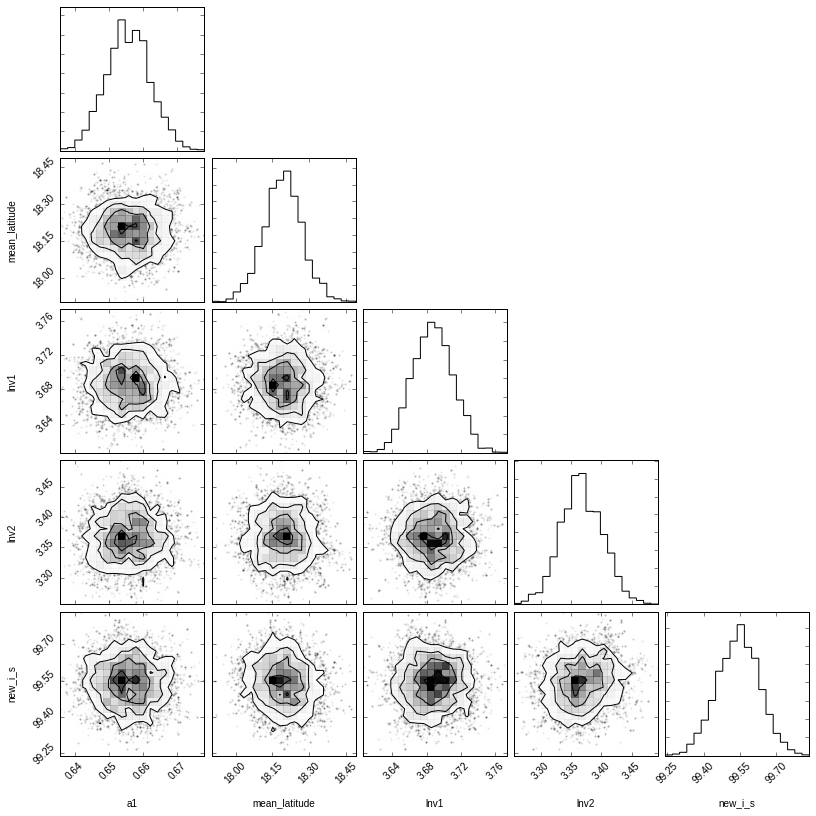

In [21]:
burnin = 500
samples_sun = sampler_sun.chain[:, burnin:, :].reshape((-1, ndim))

import corner 

# a1, m1, v1, a2, m2, v2
labels = "a1, mean_latitude, lnv1, lnv2, new_i_s".split(', ')
fig = corner.corner(samples_sun, labels=labels)

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


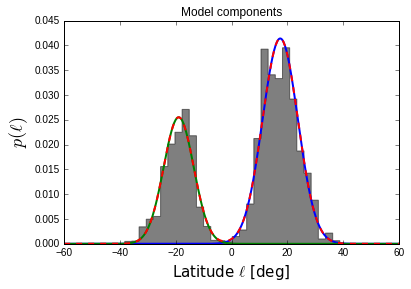

In [22]:
bestp_sun = np.median(samples_sun, axis=0)

delta_i_s = transit_params.inc_stellar - bestp_sun[4]
l1 = bestp_sun[1] - delta_i_s
l2 = -bestp_sun[1] - delta_i_s
components = np.array([gaussian(test_lats, l1, bestp_sun[2], bestp_sun[0]), 
                       gaussian(test_lats, l2, bestp_sun[3], 1-bestp_sun[0])]).T

plt.hist(solar_lats, 30, normed=True, 
         alpha=0.5, histtype='stepfilled', color='k')

plt.title('Model components')
plt.plot(test_lats, components, lw=2)
plt.plot(test_lats, model(bestp_sun, test_lats), ls='--', lw=2)
plt.legend(loc='upper left')
plt.xlabel('Latitude $\ell$ [deg]', fontsize=15)
plt.ylabel('$p(\ell)$', fontsize=18)
plt.show()

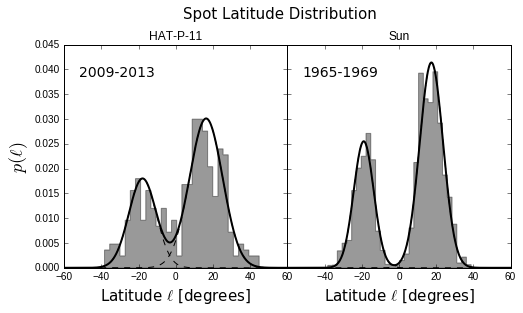

In [23]:
#dropbox_path = '/Users/bmmorris/Dropbox/Apps/ShareLaTeX/STSP_HAT-P-11/'
dropbox_path = '/astro/users/bmmorris/Dropbox/Apps/ShareLaTeX/STSP_HAT-P-11/'

fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)

n_bins = 30
hist_kwargs = dict(normed=True, histtype='stepfilled', 
                   alpha=0.4, color='k')

ax[0].hist(significant_latitudes, n_bins, **hist_kwargs)
ax[0].plot(test_lats, model_components(bestp, test_lats), '--k')
ax[0].plot(test_lats, model(bestp, test_lats), '-k', lw=2)
ax[0].set_xlabel('Latitude $\ell$ [degrees]', fontsize=15)
ax[0].set_ylabel('$p(\ell)$', fontsize=18)
ax[0].set_title('HAT-P-11')

ax[1].hist(solar_lats, n_bins, **hist_kwargs)
ax[1].plot(test_lats, model_components(bestp_sun, test_lats), '--k')
ax[1].plot(test_lats, model(bestp_sun, test_lats), '-k', lw=2)
ax[1].set_xlabel('Latitude $\ell$ [degrees]', fontsize=15)
#ax[1].set_ylabel('$p(\ell)$', fontsize=18)
ax[1].set_title('Sun')
plt.draw()
newticks = [l.get_text() for l in ax[1].get_xticklabels()]
ax[1].set_xticklabels([''] + newticks[1:])

ax[0].annotate('2009-2013', (-52, 0.038), va='bottom', fontsize=14)
ax[1].annotate('{0}-{1}'.format(start_time.datetime.year, end_time.datetime.year), 
               (-52, 0.038), va='bottom', fontsize=14)

fig.suptitle('Spot Latitude Distribution', fontsize=15, va='bottom')
fig.subplots_adjust(wspace=0.0)
fig.savefig(os.path.join(dropbox_path, 'figures', 'asymmetric_latitudes.png'), 
            bbox_inches='tight', dpi=1500)

Find asymmetric four-year spans:

In [24]:
year_bins = np.arange(1919, 1983)

asymmetry = []
for i in range(len(year_bins)):
    start = Time(datetime.datetime(year_bins[i]-2, 1, 1))
    end = start + 2*u.year
    in_time_bin = (table['jd'] > start.jd) & (table['jd'] < end.jd)
    north_count = np.count_nonzero(table['latitude_day_1'][in_time_bin] > 0)
    south_count = np.count_nonzero(table['latitude_day_1'][in_time_bin] < 0)

    asymmetry.append((north_count - south_count)/(north_count + south_count))
asymmetry = np.array(asymmetry)

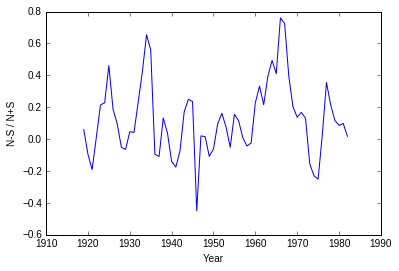

In [25]:
plt.plot(year_bins, asymmetry)
plt.xlabel('Year')
plt.ylabel('N-S / N+S')
plt.show()